# How to Train YOLOv5 on Custom Objects

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

## Install Dependencies

In [1]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16631, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 16631 (delta 62), reused 68 (delta 31), pack-reused 16522
Receiving objects: 100% (16631/16631), 15.10 MiB | 8.10 MiB/s, done.
Resolving deltas: 100% (11421/11421), done.
/home/triton_drone_replenishment/yolo_playground/helipad_venv/yolov5


Create a `HOME` variable to store the directory

In [4]:
import os
HOME = os.getcwd()
print(HOME)

/home/triton_drone_replenishment/yolo_playground/helipad_venv/yolov5


In [2]:
%pip install -qr requirements.txt  # install dependencies (ignore errors)
%pip install utils
import torch

from IPython.display import Image, clear_output  # to display images

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
     

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Setup complete. Using torch 2.3.0+cu121 _CudaDeviceProperties(name='NVIDIA RTX A6000', major=8, minor=6, total_memory=48669MB, multi_processor_count=84)


## Installing Correctly Formatted Custom Dataset from Roboflow

Go to https://app.roboflow.com/ and import all images that you have there. Create boundry boxes and label the classes.

Copy and paste Roboflow project link after you are done with Roboflow (When you click export).

In [5]:
!pwd

/home/triton_drone_replenishment/yolo_playground/helipad_venv/yolov5


In [4]:
%cd {HOME}

%pip install -U roboflow

### Paste the link below, or fill in the missing fields

from roboflow import Roboflow
rf = Roboflow(api_key="<you_key>")
project = rf.workspace("<workspace_name>").project("<project_name>")
version = project.version("<project_version>")
dataset = version.download("yolov5")


Requirement already up-to-date: roboflow in /home/triton_drone_replenishment/yolo_playground/helipad_venv/lib/python3.8/site-packages (1.1.30)
Note: you may need to restart the kernel to use updated packages.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to helipad_detection-4 in yolov5pytorch:: 100%|██████████| 3012/3012 [00:00<00:00, 8881.82it/s]


## Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [6]:
!ls

benchmarks.py	 detect.py	      models		segment
CITATION.cff	 export.py	      pyproject.toml	train.py
classify	 helipad_detection-4  README.md		tutorial.ipynb
CONTRIBUTING.md  hubconf.py	      README.zh-CN.md	utils
data		 LICENSE	      requirements.txt	val.py


In [7]:
# define number of classes based on YAML
# make sure that the file you imported from Roboflow is located in yolov5 folder
import yaml
with open(f"{dataset.location}/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])


In [8]:
%cat "{dataset.location}/data.yaml"

names:
- circle-target
- landing-pads
nc: 2
roboflow:
  license: CC BY 4.0
  project: helipad_detection-2zrua
  url: https://universe.roboflow.com/uav-replenishment/helipad_detection-2zrua/dataset/4
  version: 4
  workspace: uav-replenishment
test: ../test/images
train: helipad_detection-4/train/images
val: helipad_detection-4/valid/images


In [9]:
#this is the model configuration we will use for our tutorial 
%cat "models/yolov5s.yaml"

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 

In [10]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [11]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

## Train Custom YOLOv5 Detector
### Next, we'll fire off training!
Here, we are able to pass a number of arguments:

- **img**: define input image size
- **batch**: determine batch size
- **epochs**: define the number of training epochs. (Note: often, 3000+ are common here!)
- **data**: set the path to our yaml file
- **cfg**: specify our model configuration
- **weights**: specify a custom path to weights.
- **name**: result names
- **nosave**: only save the final checkpoint
- **cache**: cache images for faster training

**NOTE:** Training may take anywhere from 10 minutes to 18 hours depending on your dataset, training parameters and GPU

In [13]:
# train yolov5s on custom data for 150 epochs
# time its performance
%time
!python train.py --img 416 --batch 16 --epochs 150 --data '{dataset.location}/data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache
     

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/home/triton_drone_replenishment/yolo_playground/helipad_venv/yolov5/helipad_detection-4/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-315-g892e8a82 Python-3.8.10 torch-2.3.0+cu121 CUDA:0 (NVIDIA RTX

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the `--name` flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

## Evaluate Custom YOLOv5 Detector Performance


In [ ]:

# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

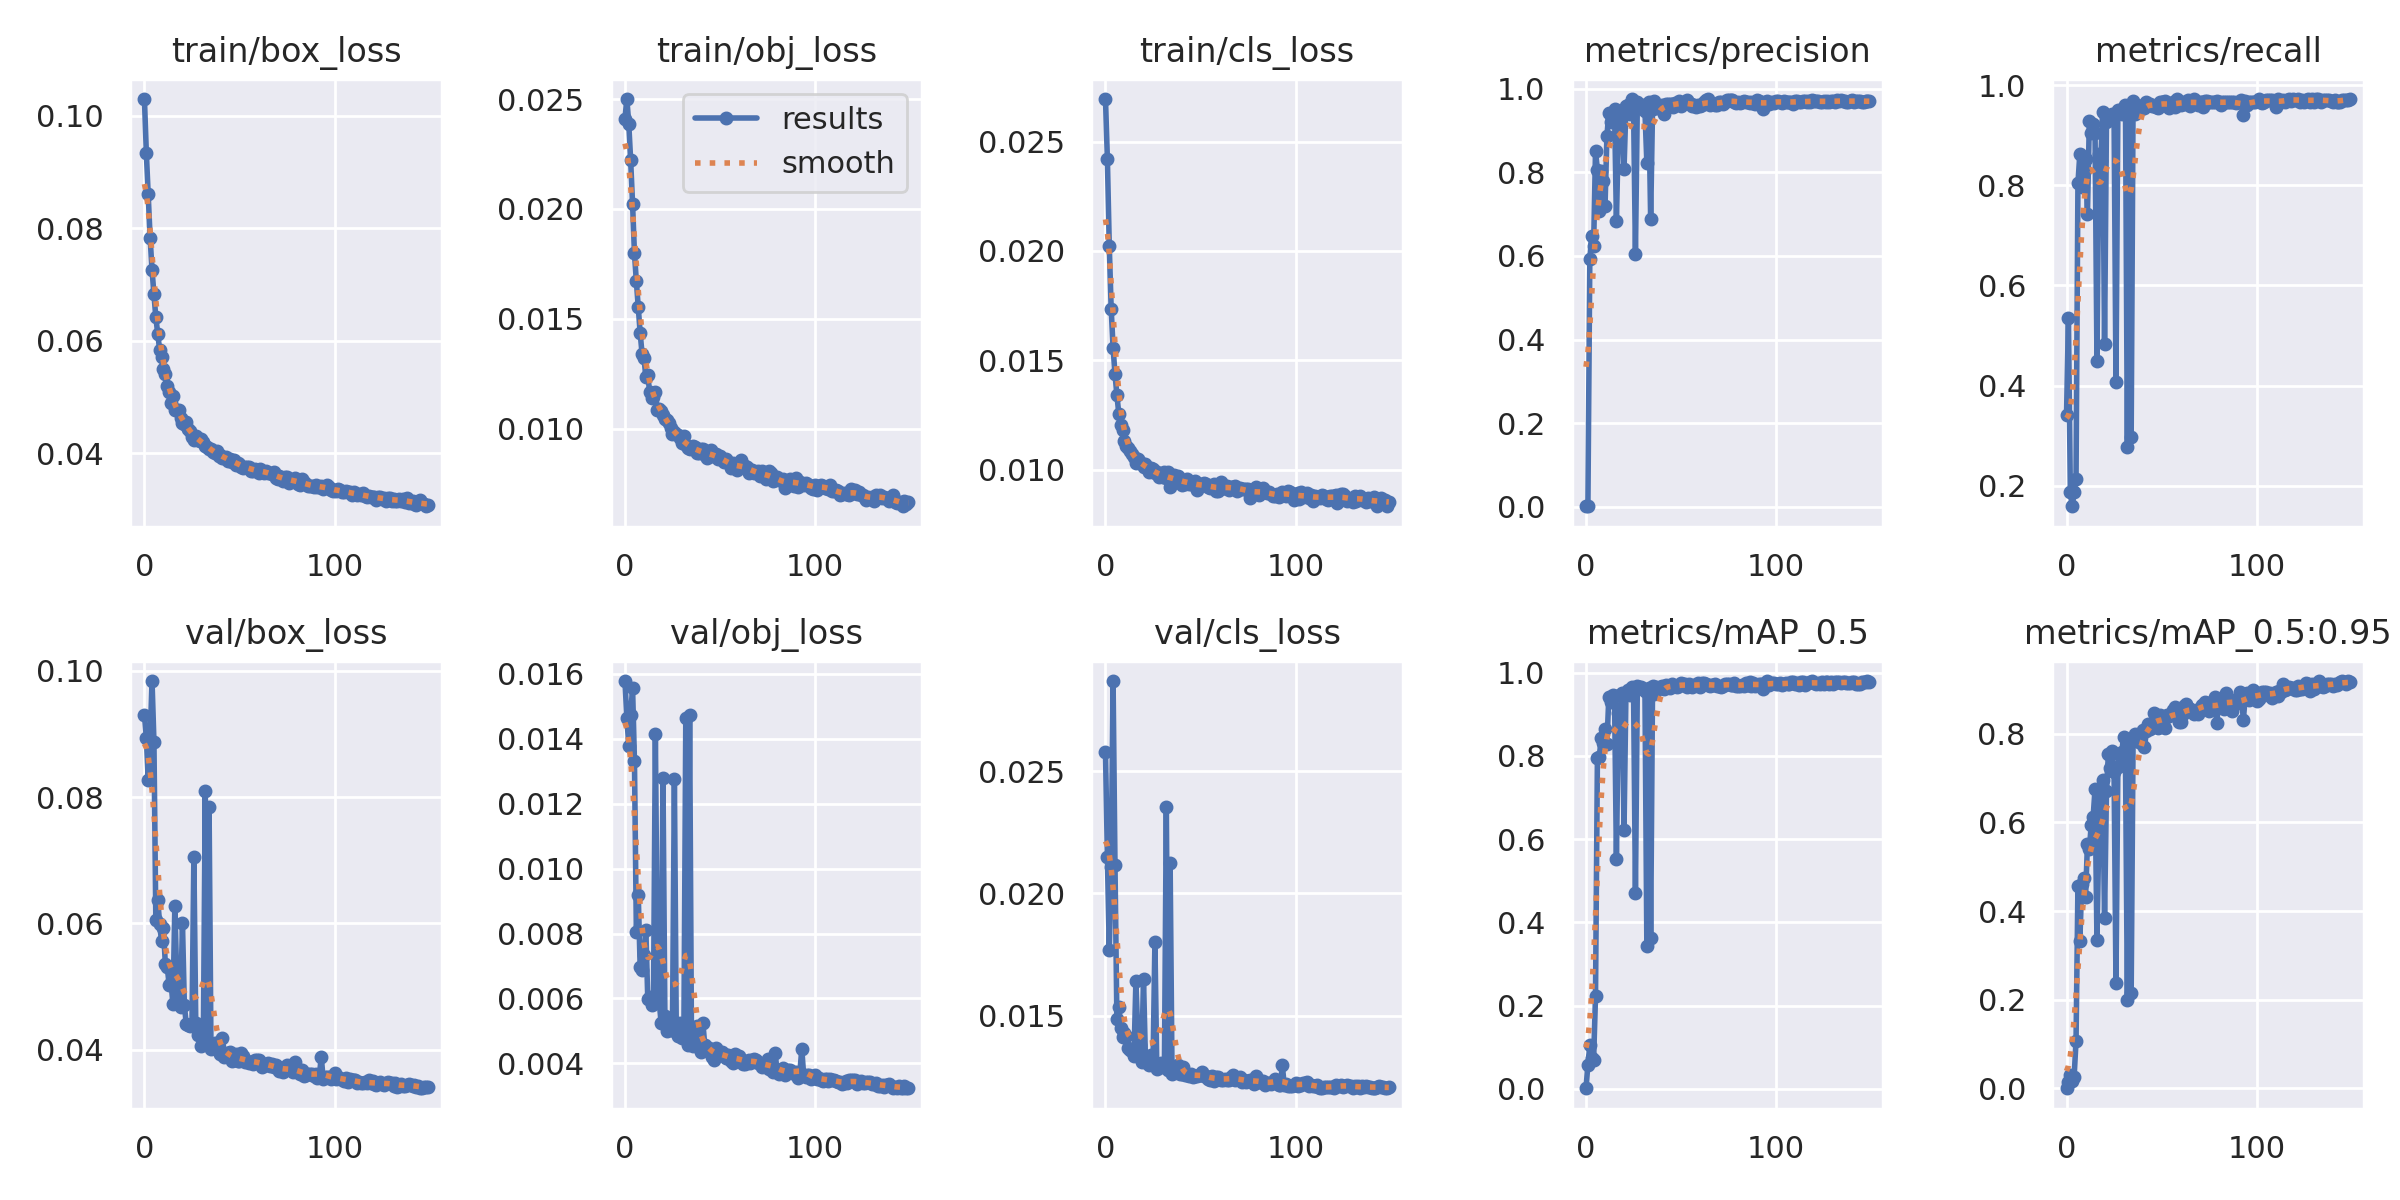

In [16]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 

from utils.plots import plot_results  # plot results.txt as results.png
Image(filename=f'{HOME}runs/train/yolov5s_results/results.png', width=1000)  # view results.png


## Visualize training data with labels

GROUND TRUTH TRAINING DATA:


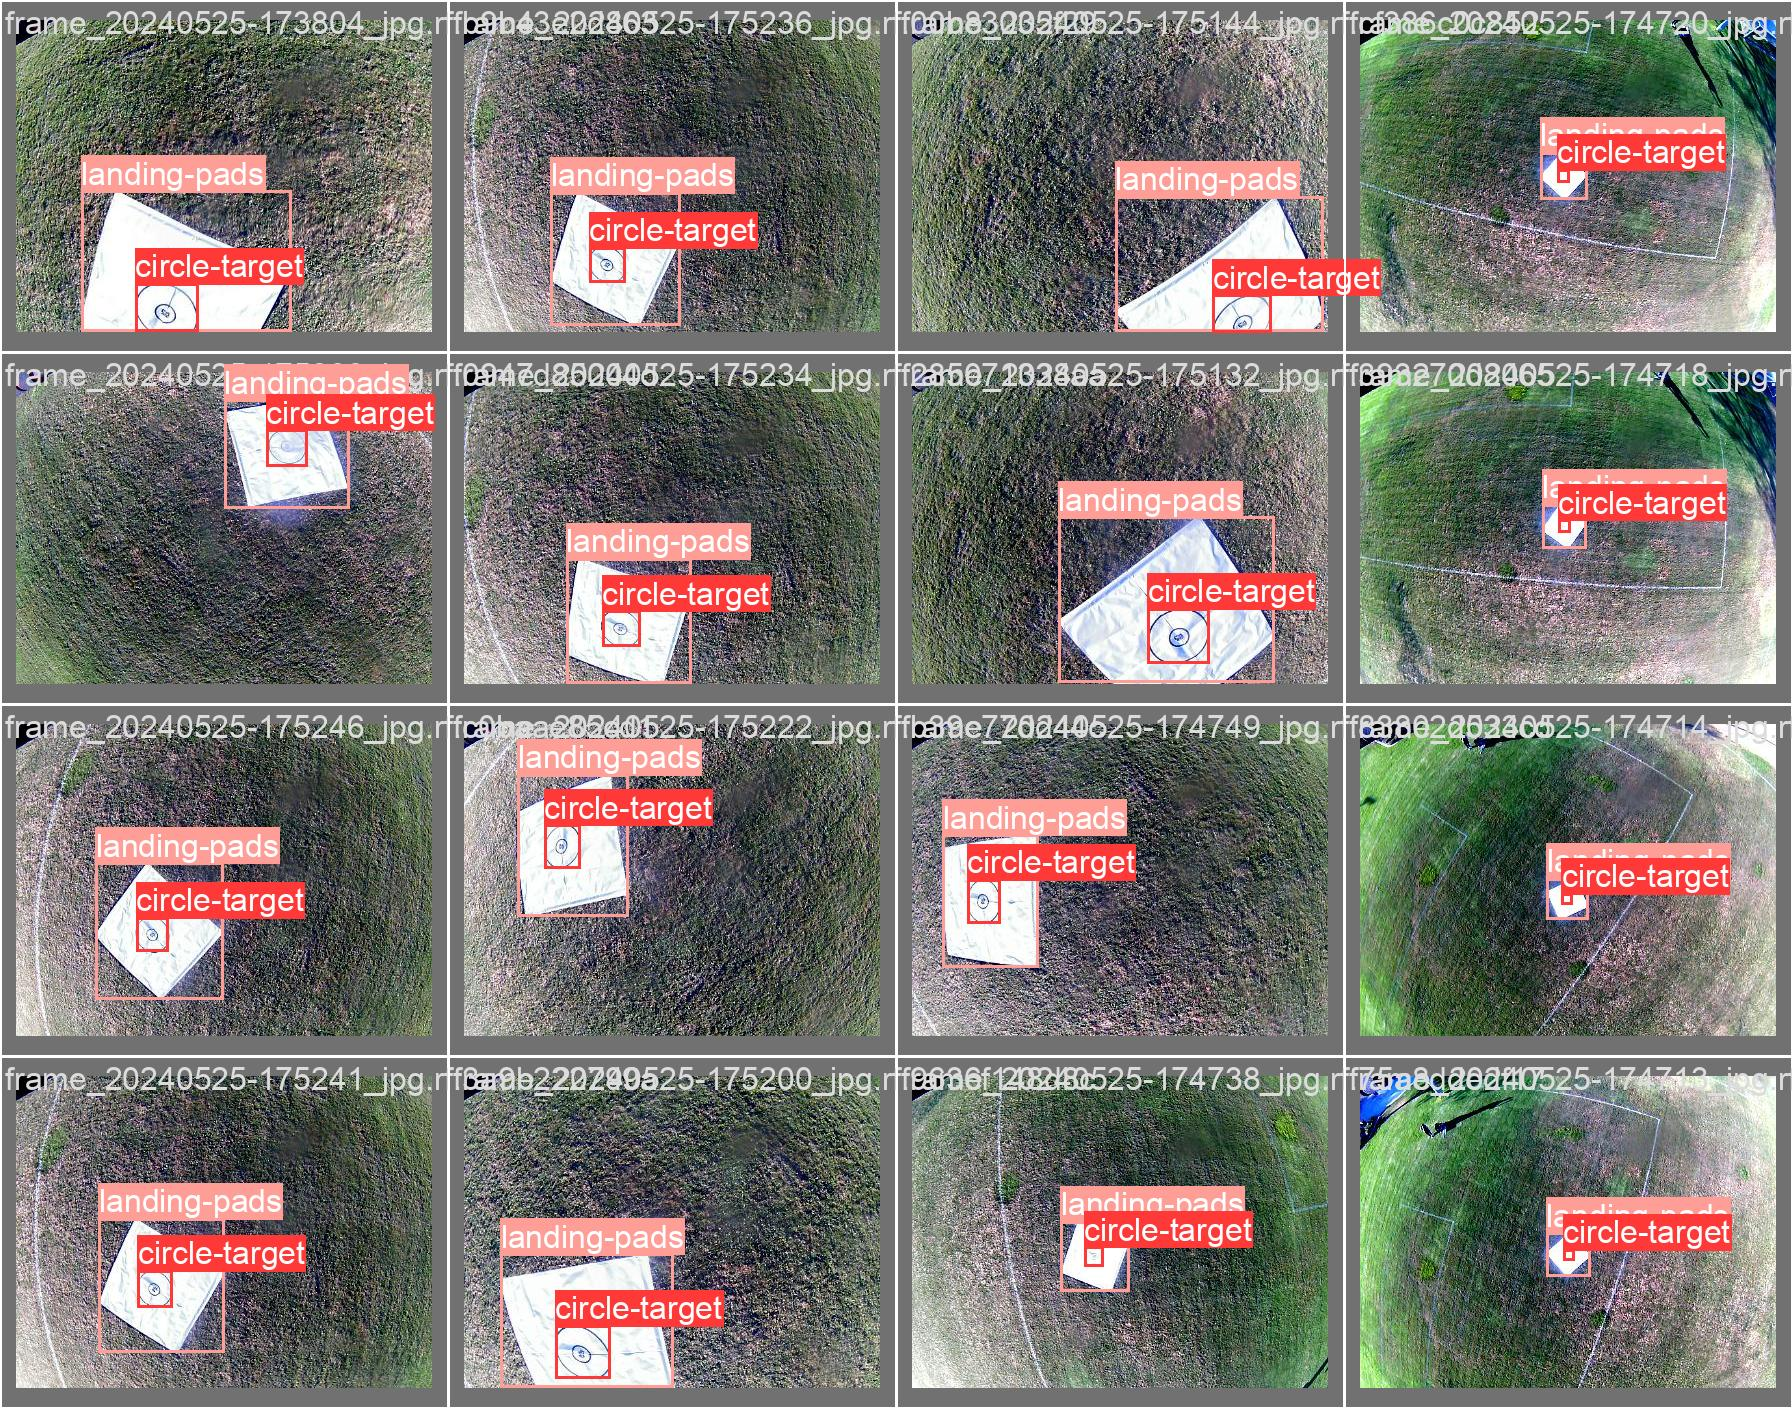

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename=f'{HOME}runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

## Inference with Custom Model

In [19]:
%cd {HOME}
!python detect.py --weights {HOME}/runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source {dataset.location}/test/images


detect: weights=['/home/triton_drone_replenishment/yolo_playground/helipad_venv/yolov5/runs/train/yolov5s_results/weights/best.pt'], source=/home/triton_drone_replenishment/yolo_playground/helipad_venv/yolov5/helipad_detection-4/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-315-g892e8a82 Python-3.8.10 torch-2.3.0+cu121 CUDA:0 (NVIDIA RTX A6000, 48670MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7249215 parameters, 0 gradients
image 1/42 /home/triton_drone_replenishment/yolo_playground/helipad_venv/yolov5/helipad_detection-4/test/images/frame_20240525-173810_jpg.rf.49766b9213751085a6cc89a2

### Visualize results

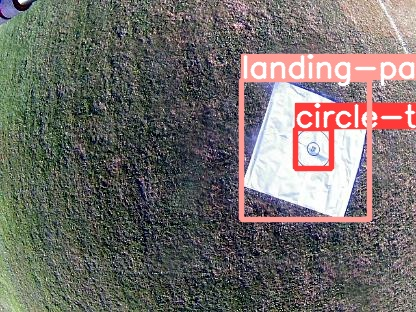

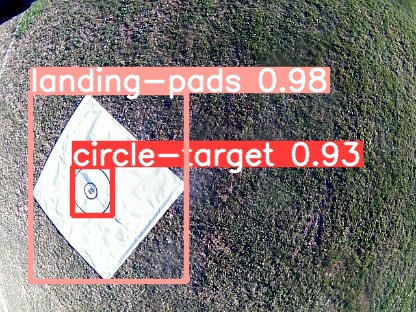

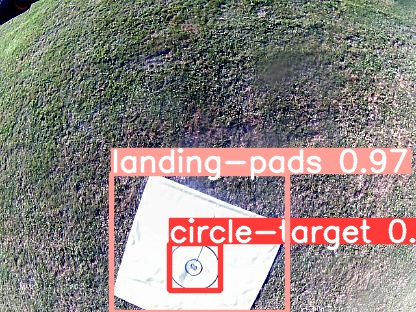

In [6]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/exp/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

## Deploy model on Roboflow

Once you have finished training your YOLOv8 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv8 weights.

To upload model weights, run the following code:

In [4]:
%cd {HOME}

/home/triton_drone_replenishment/yolo_playground/helipad_venv/yolov5


In [21]:
project.version(dataset.version).deploy(model_type="yolov5", model_path=f"{HOME}runs/train/yolov5s_results")


View the status of your deployment at: https://app.roboflow.com/uav-replenishment/helipad_detection-2zrua/4
Share your model with the world at: https://universe.roboflow.com/uav-replenishment/helipad_detection-2zrua/model/4


## 🏆 Congratulations